In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from scipy.integrate import solve_ivp
%matplotlib inline

# Replicating Blom & Peletier
The goals of this notebook are to 

1. Replicate the numerical solution in Blom & Peletier's paper (*A continuum model of lipid bilayers*). 
2. Replicate Phil and Huaxiong's results

Basic setup: A 1D domain with two population densities of lipids, $u(x)$ and $v(x)$, whose heads point in the negative and positive directions, respectively. These represent the tail distributions, so the overall tail distribution is

\begin{equation*}
\text{tails}(x) = u(x) + v(x)
\end{equation*}

The lipids are $\varepsilon$ long, so the head distribution is therefore

\begin{align*}
\text{heads} &= u(x + \varepsilon) + v(x - \varepsilon) \\
&= \tau_{-\varepsilon} u + \tau_\varepsilon v
\end{align*}

## Blom & Peletier model of interaction

We seek distributions $u, v$ that minimise the free energy
\begin{equation*}
F(u, v) = \int \eta(u) + \eta(v) + \alpha (1 - u - v)\kappa * (u + v) - \zeta(c_0)\,dx
\end{equation*}
where
\begin{equation*}
    \eta(s) = \begin{cases} 
        s \log s & \text{if } s \ge 0 \\
        \infty & \text{otherwise}
    \end{cases}
\end{equation*}
is the entropy, $\alpha$ and $\kappa$ represent the interaction of heads and tails by making tails ($u + v$) unfriendly to heads and water $(1 - u - v)$. $0 < c_0 < \frac{1}{4}$ is the background concentration (concentration at infinity) and $\zeta(c_0)$ is a constant for integrability (it doesn't really matter for our purposes). The original derivations included terms that allowed for compressibility before making the incompressibility assumption to yield these equations.

The interaction kernel is given by 
\begin{equation*}
\kappa(s) = \frac{1}{2}e^{-|s|}.
\end{equation*}

### Conservation of mass
We also have conservation of mass
\begin{equation}
\int u + v - 2c_0 \,dx = m
\end{equation}

### Density limits
and a condition making sure we don't exceed a density of $1$:
\begin{equation*}
1 - u - \tau_{-\varepsilon} u - v - \tau_\varepsilon v \ge 0
\end{equation*}


## Euler-Lagrange equations
The Euler-Lagrange equations for minimising $F(u, v)$ (including the bonus term) subject to the conservation of mass constraint are:

\begin{align*}
\log{u} - 2\alpha \kappa*(u + v) &= \lambda - \mu - \tau_\varepsilon \mu \\
\log{v} - 2\alpha \kappa*(u + v) &= \lambda - \mu - \tau_{-\varepsilon} \mu
\end{align*}

where $\lambda$ is a Lagrange multiplier, and $\mu \in L^\infty(\mathbb{R})$ is also a Lagrange multiplier which is nonzero only where the saturation condition holds exactly.

With an infinite domain, $\lambda$ can be found by looking at infinity where $\mu = 0$ and $u, v = c_0$, giving $u = v$ and hence $\lambda = \log c_0 - 4\alpha c_0$.



### Constrained gradient flow solution

We incorporate the saturation constraint $\mu = u + \tau_{-\varepsilon}u + v + \tau_\varepsilon v - 1 \le 0$ by adding a penalty term to $F(u, v)$. Blom and Peletier used a term of the form

$$
\frac{K}{2}\int (\mu_+)^2\,dx
$$

which leads to equations
\begin{align*}
u_t &= -\log u + 2\alpha\kappa*(u + v) + \lambda - K(\mu_+ + \tau_\varepsilon \mu_+) \\
v_t &= -\log v + 2\alpha\kappa*(u + v) + \lambda - K(\mu_+ + \tau_{-\varepsilon} \mu_+)
\end{align*}

where $(\cdot)_+ = \textrm{max}(0, \cdot)$. However this leads to difficulties as it makes the objective function non-differentiable, which causes problems for ODE solvers. An alternative is to instead use a logarithmic or inverse function barrier method. I feel like the latter is preferable, but we'll see. So we instead use for our penalty term

$$
K\int \frac{-1}{\mu}\,dx
$$

the idea being that it's very small unless $\mu$ is very close to zero, in which case it grows rapidly in the positive direction. Presumably things work smoothly enough during the solve that $\mu$ never jumps over the vertical asymptote. This leads to the gradient flow equations on $[-L, L]$:

\begin{align*}
u_t &= -\log u + 2\alpha\kappa*(u + v) + \lambda - K\left(\frac{1}{\mu^2} + \frac{1}{\tau_\varepsilon \mu^2}\right) \\
v_t &= -\log v + 2\alpha\kappa*(u + v) + \lambda - K\left(\frac{1}{\mu^2} + \frac{1}{\tau_{-\varepsilon} \mu^2}\right)
\end{align*}


We cannot yet solve these numerically as the Lagrange multiplier $\lambda$ is unknown. But it makes sense we have an unknown still, we haven't taken into account conservation of mass:

We have the additional constraint that $\int u + v - 2c_0\,dx = m$, or, differentiating,
\begin{equation*}
  \int_{-L}^L u_t + v_t\,dx = 0.
\end{equation*}

We can see that 
\begin{equation*}
  \int_{-L}^L u_t + v_t\,dx = \int_{-L}^L -\log u - \log v + 2\lambda + 
  4\alpha\kappa*(u + v) - K\left(\frac{2}{\mu^2} + \frac{1}{\tau_\varepsilon \mu^2} + \frac{1}{\tau_{-\varepsilon} \mu^2}\right)\,dx = 0
\end{equation*}
but $\lambda$ is not a function of $x$, so
\begin{equation*}
  \lambda = \frac{1}{4L}\int_{-L}^L \log u + \log v - 
  4\alpha\kappa*(u + v) + K\left(\frac{2}{\mu^2} + \frac{1}{\tau_\varepsilon \mu^2} +\frac{1}{\tau_{-\varepsilon} \mu^2}\right)\,dx
\end{equation*}
The right hand side of the ODE system is now fully specified, and can be solved numerically.

# Solving in Python

Problem domain, parameters, interaction kernel, and initial conditions are all specified here. We're assuming periodic boundaries for now (for convenience), `convolve1d` can handle this with the `wrap` option.

If we change the boundary condition to a different type, we'll need to modify how we do the interaction

In [15]:
# Domain
L = 30
dx = 0.1
x = np.arange(-L, L + dx, dx)
N = x.shape[0]

# Parameters
eps = 5 # Needs to be a multiple of dx
K = 1e-5 # 1e-4 seems to work, the smaller the better
alpha = 8 # B&P has 4, but this doesn't give a good result
c_0 = 0.0625

# Interaction kernel
x_ker = np.arange(-10, 10+dx, dx)
kappa = 0.5*np.exp(-np.abs(x_ker))

# Initial conditions - guassians centred on x_u and x_v with std dev sigma. 
x_u = -5
x_v = 5
sigma = 20 
m = 1 # mass of lipids

## Perform the solve
At the moment we get a warning that `np.log` is receiving negative values. I don't think this an issue, because I think the solver then discards that step, so the issue doesn't propagate. Would appreciate confirmation of this though.

In [24]:
# Do the solve

# Set up shifting functions - using periodic boundary conditions
n_eps = int(np.round(eps/dx)) # number of grid points to shift
def tau_e_plus(y):
    return np.roll(y, n_eps)

def tau_e_minus(y):
    return np.roll(y, -n_eps)

def convolve_with_kappa(y):
    return dx*convolve1d(y, kappa, mode='wrap')

def free_energy(u, v):
    kuv = convolve_with_kappa(u + v)
    return np.sum(u*np.log(u) + v*np.log(v) + alpha*(1 - u - v)*kuv)*dx

def rhs_bp(t, y):
    u = y[0:N]
    v = y[N:]
    
    # mu = K*np.maximum(u + tau_e_minus(u) + v + tau_e_plus(v) - 1, 0)
    mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
    kuv = convolve_with_kappa(u + v)
    
    # calculate derivatives with lambda absent (c.f. equations above)
    ut_i = -np.log(u) + 2*alpha*kuv - K/mu**2 - K/(tau_e_plus(mu)**2)
    vt_i = -np.log(v) + 2*alpha*kuv - K/mu**2 - K/(tau_e_minus(mu)**2)
    
    # Total change in ut and vt should be zero (conservation of mass)
    lam = -(np.sum(ut_i) + np.sum(vt_i))/(2*N)
    
    # Actual derivatives need lambda added on
    return np.concatenate((ut_i + lam, vt_i + lam))

# Initial conditions
u0 = c_0 + m/(2*sigma*np.sqrt(np.pi))*np.exp(-0.5*((x - x_u)/sigma)**2)
v0 = c_0 + m/(2*sigma*np.sqrt(np.pi))*np.exp(-0.5*((x - x_v)/sigma)**2)
y0 = np.concatenate((u0, v0))

soln = solve_ivp(rhs_bp, (0, 2), y0, method='Radau')

# Calculate the free energy over the solution
F = np.array([free_energy(y[:N], y[N:]) for y in soln.y.T])


/var/folders/6f/vgnjt9l93296jgknw1rh37tm0000gn/T/ipykernel_60465/302870715.py:26: RuntimeWarning: invalid value encountered in log
  ut_i = -np.log(u) + 2*alpha*kuv - K/mu**2 - K/(tau_e_plus(mu)**2)
/var/folders/6f/vgnjt9l93296jgknw1rh37tm0000gn/T/ipykernel_60465/302870715.py:27: RuntimeWarning: invalid value encountered in log
  vt_i = -np.log(v) + 2*alpha*kuv - K/mu**2 - K/(tau_e_minus(mu)**2)


Text(0.5, 1.0, 'Saturation $\\mu$')

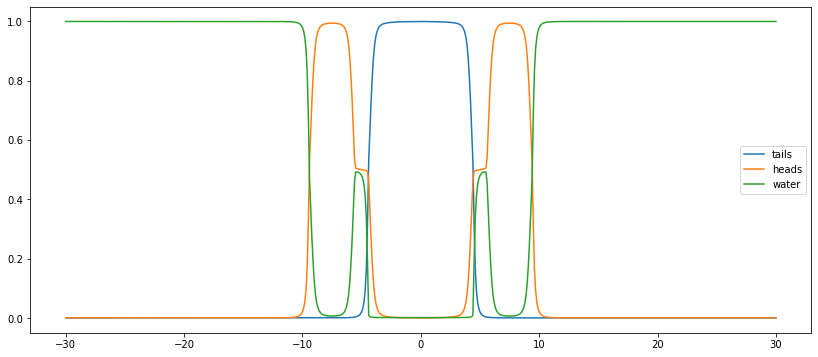

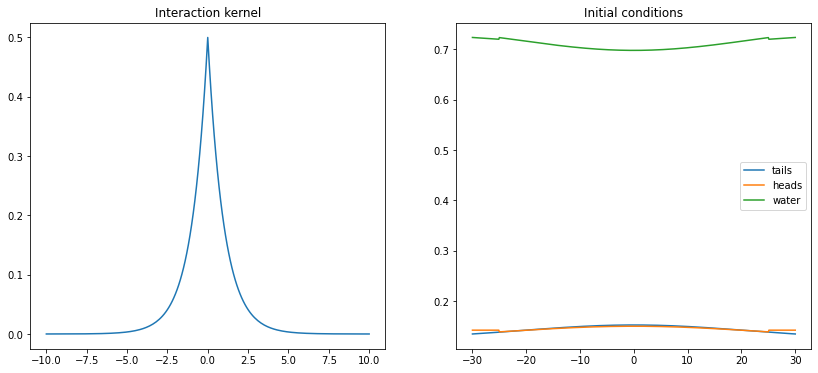

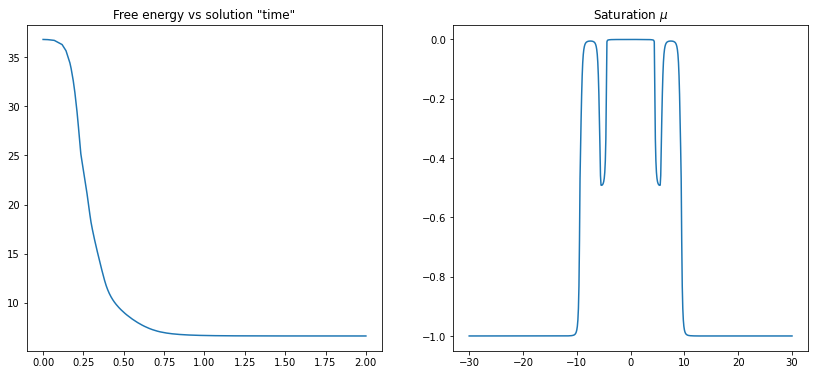

In [26]:
# Plot everything
def plot_solution(u, v):
    tails = u + v
    heads = tau_e_minus(u) + tau_e_plus(v)
    water = 1 - heads - tails
    plt.plot(x, tails, x, heads, x, water)
    plt.legend(('tails', 'heads', 'water'))

plt.figure(figsize=(14, 6))
u = soln.y[:N, -1]
v = soln.y[N:, -1]
plot_solution(u, v)

plt.subplots(1,2, figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(x_ker, kappa)
plt.title("Interaction kernel")

plt.subplot(1,2,2)
plot_solution(u0, v0)
plt.title('Initial conditions')

plt.subplots(1,2, figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(soln.t, F)
plt.title("Free energy vs solution \"time\"")

mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
plt.subplot(1,2,2)
plt.plot(x, mu)
plt.title("Saturation $\mu$")